<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epid_MCMC_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import odeint

Cargamos los datos de incidencia durante 28 semanas.

924122


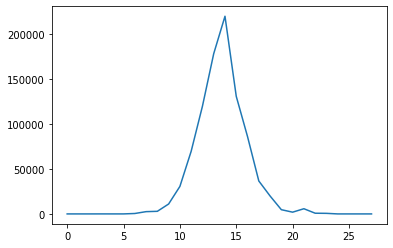

In [9]:
datos=pd.read_csv("SEIR.csv",sep=';')
plt.plot(datos['incidencia'])
Ydat=datos['incidencia']
print(np.sum(Ydat))#>90% de la población se infectó

Definimos la función del modelo SEIR que utilizaremos para ajustar los datos observados.

In [10]:
N=1e6
S0=N-1
E0=1
I0=0
R0=0
X0=[S0,E0,0,I0,R0]
INPUT=[S0,E0,I0,0,R0]
def SEIR(X,t, ps):
    try:
        be = ps['be'].value
        la = ps['la'].value
        ga = ps['ga'].value
        N = ps['N'].value
    except:
        be,la,ga,N = ps  
    S,E,I,Y,R = X
    dS = -be*S*I/N
    dE = (be*S*I/N) - la*E
    dI = la*E - ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dE,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(5,)
    return(Xsol)
def SEIR_izy(X,t, N, be,la,ga):#Para no tener problemas con los parametros de las funciones.
    S,E,I,Y,R = X
    dS = -be*S*I/N
    dE = (be*S*I/N) - la*E
    dI = la*E - ga*I
    dY = be*S*I/N
    dR = ga*I
    Xsol = np.array([dS,dE,dI,dY,dR],dtype='float64')
    Xsol = Xsol.reshape(5,)
    return(Xsol)

En este ejercicio, nos gustaría hacer inferencia bayesiana sobre la distribución de los datos de incidencia. En tal caso, supongamos el siguiente esquema de trabajo.


*   D=$\{y_1,y_2,\ldots,y_{28}\}$ son los datos de incidencia.
*  Debemos proponer $\pi_{1,2,3}$ distribuciones aprior de los parámetros de nuestro modelo SEIR ($\beta,\lambda,\gamma)$ respectivamente. Pues con estas y asumiendo un modelo Poisson para la incidencia, podemos calcular la función de verosimilitud de nuestros datos.
*   $Y|D$ la distribución posterior es la distribución objetivo. Es decir, de la que nos gustaría generar observaciones. Llamemosla $f$.
*   Debemos proporcionar un valor inicial de la cadena $x_0$ que satisfaga que $f(x_0)>0$, de manera que el algoritmo pueda generar realizaciones de la distribución de interés.

Función de verosimilitud de las observaciones. En este caso $f$ es la función de distribución posterior usando el modelo $Poisson$. La única razón para elegir una distribución Poisson es asegurarnos que los valores de la distribución sean enteras, pues estamos trabajando con número de personas.

In [11]:
#### verosimilitud
def logverosimilitud(theta):
    be,la,ga = theta
    dias = 28
    t = np.linspace(0,28,29)  ## vector de tiempos
    Xt =  odeint(func=SEIR_izy, y0=X0, t=t, args=(N,be,la,ga))
    ### Incidencia
    Inc = np.diff(Xt[:,3])#Valores de incidencia diaria.
    vers = scipy.stats.poisson.logpmf(Ydat, Inc)#Suponiendo que dado theta, los datos siguen distribucion 
            #Poisson de parámetro dado por el valor obtenido en la solución de la ODE
    ver = np.sum(vers)
    return(ver)
#### Posterior (Es más fácil trabajar con -log(Posterior))
def minuslogposterior(theta):
  return(-(logaprioris(theta)+logverosimilitud(theta)))


Usamos optimización numérica para conseguir una condición inicial de los parámetros y guiarnos para proponer las aprioris.

In [12]:
!pip install lmfit  #Solo correr una vez

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 4.1 MB/s 
     |████████████████████████████████| 98 kB 6.7 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84413 sha256=f11faf4c3ff72b4f9ba27960b37c08b9adecb75208197d1855837719f1ecb85a
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit


In [13]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import scipy.integrate as spi
t_start = 0.0; 
t_end = 28; 
t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)
def g(t,ps):
    SOL = spi.odeint(SEIR,INPUT,t_range,args=(ps,))
    return np.diff(SOL[:,3])
def residual(ps,ts,data):
    #INP =  ps['Y0'].value#Solo los infectados.
    model = g(ts,ps)
    return (model-data).ravel()
params = Parameters()
params.add('be', value=2.0, min=0, max=10)
params.add('la', value=2, min=0, max=10)
params.add('ga', value=1, min=0, max=10)
params.add('N', value=float(N), min=N, max=N+1)
params.add('S0', value= float(N), min=0, max=N+1)
params.add('E0', value=float(1), min=0, max=1)
params.add('I0', value=float(0), min=0, max=1)
params.add('Y0', value=float(0), min=0, max=1)
t = np.linspace(0, 28, 29)
result = minimize(residual, params, args=(t, Ydat), method='leastsq')

final = Ydat + result.residual.reshape(Ydat.shape)
result


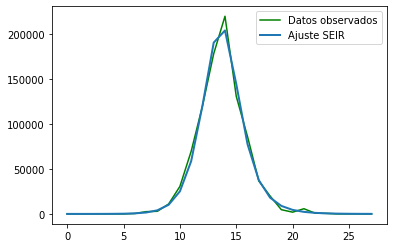

In [14]:
plt.plot(Ydat, '-g',label='Datos observados')
plt.plot(final, '-', linewidth=2,label='Ajuste SEIR');
plt.legend()
plt.show()

In [15]:
be_0=result.params['be'].value
la_0=result.params['la'].value
ga_0=result.params['ga'].value
x0=[be_0,la_0,ga_0]#Primer propuesta de la cadena en pytwalk()
print(x0)

[2.5242575167008976, 2.816105657967901, 0.9439395288082381]


In [16]:
par1=[be_0,0,1]  #hiperparametros para beta
par2=[la_0,0,1]  #hiperparametros para lamba
par3=[ga_0,0,1]  #hiperparametros para gamma

def logaprioris(theta):
    be,la,ga = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dla = scipy.stats.gamma.logpdf(la,par2[0],par2[1],par2[2])
    dga = scipy.stats.gamma.logpdf(ga,par3[0],par3[1],par3[2])
    return(dbe+dla+dga)

Visualización de las distribuciones a prior. Utilizaremos distribuciones Gamma por simplicidad, pues satisfacen que su soporte es $(0,\infty)$, y podemos controlar el valor de su media fácilmente a través de sus parámetros.

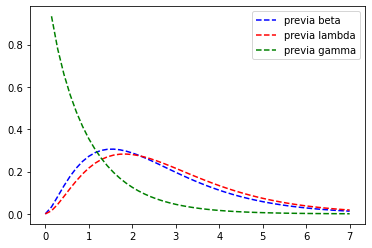

In [17]:
x = np.linspace(0., 7, 50)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
prev3 = scipy.stats.gamma.pdf(x, par3[0],par3[1],par3[2])
plt.plot(x, prev1, 'b--', label='previa beta')
plt.plot(x, prev2, 'r--', label='previa lambda')
plt.plot(x, prev3, 'g--', label='previa gamma')
plt.legend(loc="best")

Buscamos numéricamente un mínimo local de la función de -log(Verosimilitud), para segunda propuesta de la cadena. 

In [28]:
#Segundo intento. Optimizacion numérica sobre la funcion de verosimilitud
from scipy.optimize import minimize
def menosloglikelihood(theta):
    return -logverosimilitud(theta)
bnds = ((0.01, 10), (0.01, 6.0),(0.01, 6.0))
xp0=minimize(fun=menosloglikelihood,x0=[be_0,la_0,ga_0],bounds=bnds).x#Segundo valor de la cadena en pytwalk()


Hasta ahora tenemos candidatos $x_0$, $xp0$ obtenidos con métodos numéricos. (Nada nos asegura que no sean idénticos). Utilizaremos pytwalk, una función que realiza el algoritmo de caminata aleatoria. Los parámetros son el número de iteraciones deseadas (rechazadas + aceptadas), la función de energía, en nuestro caso, -log de la distribución posterior, y dos propuestas iniciales de la cadena.

In [20]:
import pytwalk#Añadir el archivo .py a los archivos de colab

Consideraremos $E_0=150$ el número inicial de personas expuestas, pues notamos que pytwalk() encuentra menos errores numéricos.

Deshechamos el $\%15$ de las propuestas aceptadas de nuestra caminata aleatoria, la razón de esto es porque en teoría, la cadena tiene distribución límite $f$, nuestra distribución de interés, así que nos interesa la cadena en sus últimos estados. Este término se conoce como calentamiento.

pytwalk: Running the twalk with 100000 iterations .  Wed, 19 Oct 2022, 20:48:07.
       Finish by Wed, 19 Oct 2022, 21:08.
pytwalk:      11264 iterations so far. Finish in approx. 4 min and 15 sec.
pytwalk:      32768 iterations so far. Finish in approx. 3 min and 11 sec.
pytwalk:      76800 iterations so far. Finish in approx. 1 min and 5 sec.
pytwalk: finished, Wed, 19 Oct 2022, 20:52:46.
Acceptance rates for the Walk, Traverse, Blow and Hop kernels:[0.02699697 0.11833279 0.00465658 0.01509434]
Global acceptance rate: 0.07137
AutoMaxlag: maxlag= 262.
Integrated Autocorrelation Time:    45.1, IAT/n:    15.0
AutoMaxlag: maxlag= 262.


matrix([[45.06118595]])

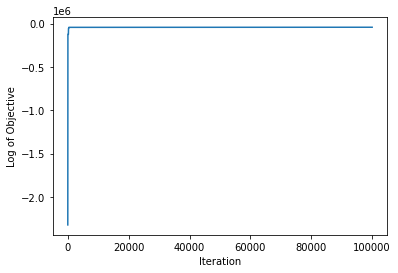

In [31]:
np.random.seed(1)
t=np.arange( 0,len(Ydat)+1,1 )
t0=t[0:28]
I0=1
Y0=1
X0=np.array( [N-I0, 150, I0 ,Y0, 0] )#
T=int(1e5) #iterations
bi=int(0.15* T)#calentamiento

tchain = pytwalk.pytwalk( n=3, U=minuslogposterior, )
tchain.Run( T=T , x0=np.array([be_0,la_0,ga_0]), xp0=xp0)

tchain.Ana()
tchain.IAT()

IAT() tiene un valor de 45, y AutoMaxLag de 262. Consideraremos un periodo $\tau=100$ de manera que las realizaciones $(x_{k\tau})_{k\geq0}$ tengan menos correlación entre ellas. Esto se verifica con la gráfica de autocorrelación, notando que disminuye hasta valores cercanos a 0.

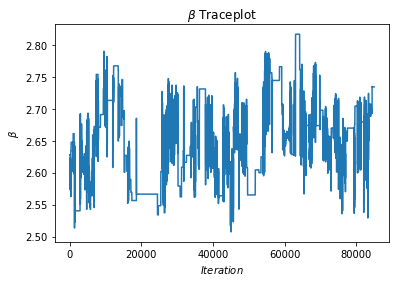

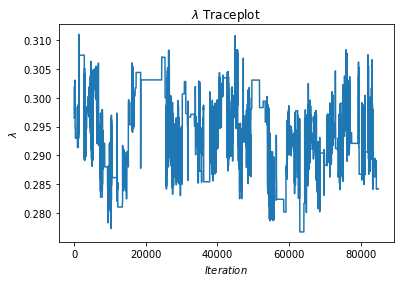

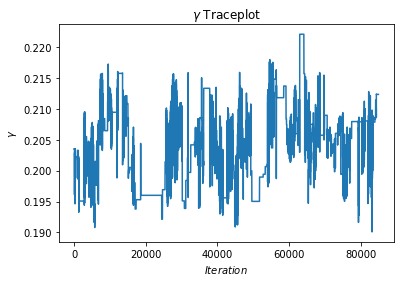

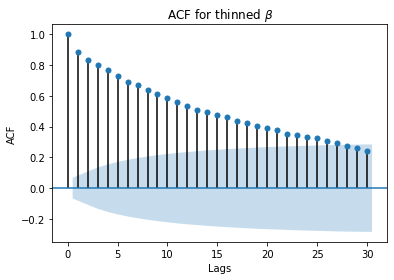

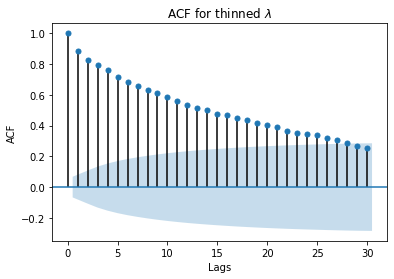

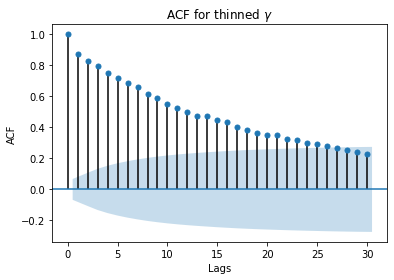

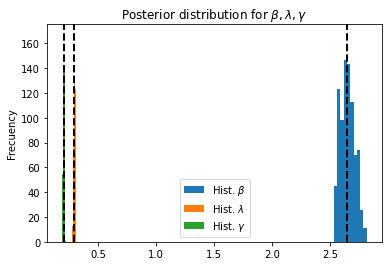

In [32]:
from scipy.stats.mstats import mquantiles
import statsmodels.api as sm
toutput=tchain.Output[ bi: ,: ] #output considerando el calentamiento
beta=toutput[:,0]
lambdda=toutput[:,1]
gamma=toutput[:,2]

#Trace plots after burn in
plt.plot(toutput[:,0])
plt.xlabel( r'$Iteration$' )
plt.ylabel( r'$\beta$' )
plt.title( r'$\beta$'+' Traceplot' )
plt.show()

plt.plot(toutput[:,1])
plt.xlabel( r'$Iteration$' )
plt.ylabel( r'$\lambda$' )
plt.title( r'$\lambda$'+' Traceplot' )
plt.show()

plt.plot(toutput[:,2])
plt.xlabel( r'$Iteration$' )
plt.ylabel( r'$\gamma$' )
plt.title( r'$\gamma$'+' Traceplot' )
plt.show()

#thin the chain 
tau=100#
indexes=np.arange(start=0,stop=T-bi, step=tau)

betas=beta[indexes]
lambdas=lambdda[indexes]
gammas=gamma[indexes]
###########plotting the ACF for beta################
sm.graphics.tsa.plot_acf(betas)
plt.xlabel('Lags') 
# naming the y axis 
plt.ylabel('ACF') 
plt.title(r'ACF for thinned $\beta$')
plt.show()
###########plotting the ACF for sigma ################
sm.graphics.tsa.plot_acf(lambdas)
plt.xlabel('Lags') 
# naming the y axis 
plt.ylabel('ACF') 
plt.title(r'ACF for thinned $\lambda$')
plt.show()
###########plotting the ACF for sigma ################
sm.graphics.tsa.plot_acf(gammas)
plt.xlabel('Lags') 
# naming the y axis 
plt.ylabel('ACF') 
plt.title(r'ACF for thinned $\gamma$')
plt.show()
######## plotting the histogram of the chains after thinning ###########
plt.hist(betas,bins=10,density=False,label=r'Hist. $\beta$')
plt.axvline(betas.mean(), color='k', linestyle='dashed', linewidth=2)
plt.ylabel("Frecuency")

plt.hist(lambdas,bins=10,density=False,label=r'Hist. $\lambda$')
plt.axvline(lambdas.mean(), color='k', linestyle='dashed', linewidth=2)
plt.ylabel("Frecuency")

plt.hist(gammas,bins=10,density=False,label=r'Hist. $\gamma$')
plt.axvline(gammas.mean(), color='k', linestyle='dashed', linewidth=2)
plt.ylabel("Frecuency")
plt.title(r"Posterior distribution for $\beta,\lambda,\gamma$")
plt.legend()
plt.show()

In [38]:
import scipy.stats
MAP_est=[scipy.stats.mode(betas).mode[0],scipy.stats.mode(lambdas).mode[0],scipy.stats.mode(gammas).mode[0]]
mean_est=[np.mean(betas),np.mean(lambdas),np.mean(gammas)]
median_est=[np.median(betas),np.median(lambdas),np.median(gammas)]
print("MAP_est: ",MAP_est) 
print("Mean_est: ",mean_est)
print("Median_est: ",median_est)


MAP_est:  [2.5663677094323365, 0.3030963493657364, 0.1960030725638863]
Mean_est:  [2.6493089776102767, 0.29377701577605386, 0.20425804705288475]
Median_est:  [2.6474979546888737, 0.2937625248304029, 0.20428423766158807]


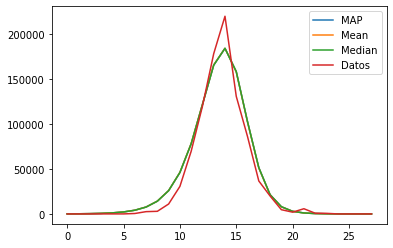

In [54]:
estimadores=[MAP_est,mean_est,median_est]
etiquetas=["MAP","Mean","Median"]
for i in range(3):
    def g(t,ps):
        SOL = spi.odeint(SEIR,[1e6-1,150,0,0,0],t_range,args=(ps,))
        return np.diff(SOL[:,3])
    plt.plot(g(np.arange(0,28,500),[estimadores[i][0],estimadores[i][1],estimadores[i][2],1e6]),label=etiquetas[i])
plt.plot(Ydat,label='Datos')
plt.legend()
plt.show()

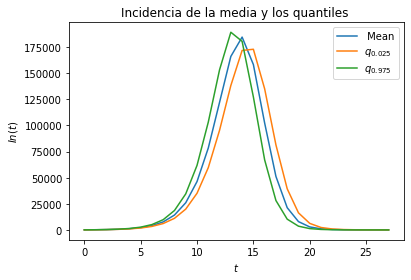

In [65]:
alpha=0.05
I0=0
Y0=0

qbetas=mquantiles(betas, prob=np.array([alpha/2, 1-alpha/2]))
qlambdas=mquantiles(lambdas, prob=np.array([alpha/2, 1-alpha/2]))
qgammas=mquantiles(gammas, prob=np.array([alpha/2, 1-alpha/2]))
#posterior mean
x0=np.array([ N-I0   , 150, I0 ,Y0 ,0  ]) #initial condition
pmean=scipy.integrate.odeint( SEIR_izy, x0, t, args= ( 1e6,np.mean(betas),np.mean(lambdas), np.mean(gamma), ) )
    
    
#lower quantile
x0=np.array([ N- I0   , 150, I0,Y0 ,0  ]) #initial condition
qlower=scipy.integrate.odeint( SEIR_izy, x0, t, args= ( 1e6,qbetas[0], qlambdas[0], qgammas[0], ) )
    
    
#upper quantile
x0=np.array([ N- I0   , 150, I0 ,Y0,0  ]) #initial condition
qupper=scipy.integrate.odeint( SEIR_izy, x0, t, args= ( 1e6,qbetas[1], qlambdas[1], qgammas[1],) )

plt.plot(t0, np.diff(pmean[:,3])  , label=' Mean' )
plt.plot(t0, np.diff(qlower[:,3]), label=r'$q_{0.025}$ ' )
plt.plot(t0, np.diff(qupper[:,3]), label=r'$q_{0.975}$ ')
plt.legend(loc="upper right")
plt.xlabel( r'$ t$' )
plt.ylabel( r'$In(t)$' )
plt.title( r'Incidencia de la media y los quantiles ')
plt.show()